# Evaluación clasificación

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

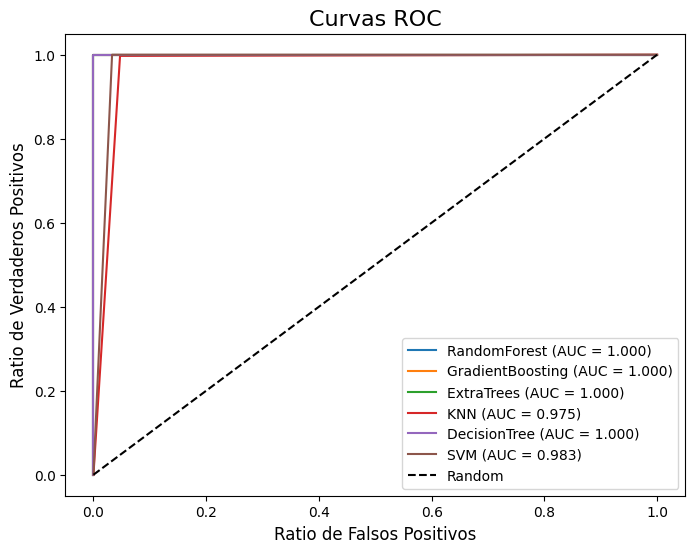

In [4]:
import pandas as pd
from sklearn import datasets
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc

cancer = datasets.load_breast_cancer(as_frame=True)

X = cancer.data
y = cancer.target

X.info()

y.value_counts()

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

sc = StandardScaler()
X_std = sc.fit_transform(X)


from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


models_clasif = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'ExtraTrees': ExtraTreesClassifier(random_state=42),
    'KNN': KNeighborsClassifier(), # 5 vecinos por defecto
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}



results_clasif = [[0] * 5 for _ in range(len(models_clasif))] 
roc_data = {}

for i, (name, model) in enumerate(models_clasif.items()):
    model.fit(X_std, y)
    y_pred = model.predict(X_std)

    # evaluamos las métricas
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    # curva roc
    fpr, tpr, _ = roc_curve(y, y_pred, pos_label=1)
    auc_score = auc(fpr, tpr)
    roc_data[name] = {'fpr': fpr, 'tpr': tpr, 'auc': auc_score}

    results_clasif[i] = [name, accuracy, precision, recall, f1, auc_score]

results = pd.DataFrame(results_clasif, columns=['Modelo', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC Score'])

print("\nMétricas:")
print(results.set_index('Modelo').round(3))

best_model = max(roc_data.items(), key=lambda x: x[1]['auc'])
best_model

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for name, data in roc_data.items():
    plt.plot(data['fpr'], data['tpr'], label=f"{name} (AUC = {data['auc']:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('Ratio de Falsos Positivos', fontsize=12)
plt.ylabel('Ratio de Verdaderos Positivos', fontsize=12)
plt.title('Curvas ROC', fontsize=16)
plt.legend(loc='lower right')
plt.show()

In [12]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold, LeaveOneOut, ShuffleSplit, GroupKFold
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedGroupKFold
from sklearn.model_selection import RepeatedKFold, StratifiedKFold, LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier
import numpy as np

iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

# grupos para GroupKFold, StratifiedGroupKFold y LeaveOneGroupOut
np.random.seed(42)
groups = np.random.randint(0, 5, size=len(y))

rf = RandomForestClassifier(n_estimators=100, random_state=42)

cv_strategies = {
    "KFold(5)": KFold(n_splits=5, shuffle=True, random_state=42),
    "StratifiedKFold(5)": StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    "RepeatedKFold(5, 3)": RepeatedKFold(n_splits=5, n_repeats=3, random_state=42),
    "RepeatedStratifiedKFold": RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42),
    #"LeaveOneOut": LeaveOneOut(),
    "ShuffleSplit(10, test_size=0.3)": ShuffleSplit(n_splits=10, test_size=0.3, random_state=42),
    "GroupkFold": GroupKFold(n_splits=5),
    "StratifiedGroupKFold": StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42),
    "LeaveOneGroupOut": LeaveOneGroupOut()
}

scoring = {
    'accuracy': 'accuracy',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro',
    'f1_macro': 'f1_macro'
}

results = []

for strategy_name, cv in cv_strategies.items():
    print(f"Evaluando {strategy_name}...") 
    
    if 'Group' in strategy_name:
        cv_results = cross_validate(rf, X, y, cv=cv, scoring=scoring, 
                                    return_train_score=True, groups=groups)
    else:
        cv_results = cross_validate(rf, X, y, cv=cv, scoring=scoring, 
                                    return_train_score=True)

    for metric_key in scoring.keys():
        test_scores = cv_results[f'test_{metric_key}']
        mean = test_scores.mean()
        std = test_scores.std()

        results.append([strategy_name, metric_key, f"{mean:.4f} ± {std:.4f}"])

resultados = pd.DataFrame(results, columns=['Strategy', 'Metric', 'Mean ± Std'])
resultados = resultados.pivot(index='Strategy', columns='Metric', values='Mean ± Std')

print("\nResumen:")
resultados

Evaluando KFold(5)...
Evaluando StratifiedKFold(5)...
Evaluando RepeatedKFold(5, 3)...
Evaluando RepeatedStratifiedKFold...
Evaluando ShuffleSplit(10, test_size=0.3)...
Evaluando GroupkFold...
Evaluando StratifiedGroupKFold...
Evaluando LeaveOneGroupOut...

Resumen:


Metric,accuracy,f1_macro,precision_macro,recall_macro
Strategy,,,,
GroupkFold,0.9658 ± 0.0051,0.9643 ± 0.0060,0.9666 ± 0.0096,0.9658 ± 0.0076
KFold(5),0.9600 ± 0.0249,0.9589 ± 0.0258,0.9628 ± 0.0243,0.9594 ± 0.0243
LeaveOneGroupOut,0.9658 ± 0.0051,0.9643 ± 0.0060,0.9666 ± 0.0096,0.9658 ± 0.0076
"RepeatedKFold(5, 3)",0.9556 ± 0.0416,0.9544 ± 0.0416,0.9598 ± 0.0393,0.9568 ± 0.0389
RepeatedStratifiedKFold,0.9556 ± 0.0314,0.9554 ± 0.0315,0.9586 ± 0.0308,0.9556 ± 0.0314
"ShuffleSplit(10, test_size=0.3)",0.9489 ± 0.0330,0.9523 ± 0.0287,0.9532 ± 0.0294,0.9536 ± 0.0267
StratifiedGroupKFold,0.9658 ± 0.0051,0.9643 ± 0.0060,0.9666 ± 0.0096,0.9658 ± 0.0076
StratifiedKFold(5),0.9467 ± 0.0267,0.9464 ± 0.0268,0.9512 ± 0.0263,0.9467 ± 0.0267


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (precision_score, recall_score, f1_score, accuracy_score, 
                           roc_curve, auc, make_scorer, roc_auc_score)
from sklearn.model_selection import (cross_validate, KFold, LeaveOneOut, ShuffleSplit, 
                                  GroupKFold, RepeatedStratifiedKFold, StratifiedGroupKFold,
                                  RepeatedKFold, StratifiedKFold, LeaveOneGroupOut)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


plt.rcParams['figure.figsize'] = (14, 10)
pd.set_option('display.precision', 4)


def load_dataset(dataset_name):
    if dataset_name == 'iris':
        data = datasets.load_iris()
        X = data.data
        y = data.target
        feature_names = data.feature_names
        target_names = data.target_names
        multi_class = True
    elif dataset_name == 'breast_cancer':
        data = datasets.load_breast_cancer(as_frame=True)
        X = data.data
        y = data.target
        feature_names = data.feature_names
        target_names = data.target_names
        multi_class = False
    else:
        raise ValueError("Dataset no soportado. Use 'iris' o 'breast_cancer'")
    
    # grupos para las estrategias basadas en grupos
    np.random.seed(42)
    groups = np.random.randint(0, 5, size=len(y))
    
    return X, y, feature_names, target_names, groups, multi_class


dataset_name = 'breast_cancer'
X, y, feature_names, target_names, groups, multi_class = load_dataset(dataset_name)

# estandarizar características
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Modelos a evaluar
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'ExtraTrees': ExtraTreesClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

# Estrategias de validación cruzada
cv_strategies = {
    "KFold(5)": KFold(n_splits=5, shuffle=True, random_state=42),
    "StratifiedKFold(5)": StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    "RepeatedKFold(5, 3)": RepeatedKFold(n_splits=5, n_repeats=3, random_state=42),
    "RepeatedStratifiedKFold": RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42),
    # "LeaveOneOut": LeaveOneOut(),
    "ShuffleSplit(10, 0.3)": ShuffleSplit(n_splits=10, test_size=0.3, random_state=42),
    "GroupKFold": GroupKFold(n_splits=5),
    "StratifiedGroupKFold": StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42),
    "LeaveOneGroupOut": LeaveOneGroupOut()
}

# Para problemas multiclase (iris)
scoring = {
    'accuracy': 'accuracy',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro',
    'f1_macro': 'f1_macro'
}
metric_display = {
    'accuracy': 'Accuracy',
    'precision_macro': 'Precision',
    'recall_macro': 'Recall',
    'f1_macro': 'F1'
}

if not multi_class: # solo para problemas de clasificación binaria
    scoring['roc_auc'] = 'roc_auc'
    metric_display['roc_auc'] = 'AUC'

# Datos completos para análisis posterior
all_results = []
model_cv_results = {}

# Evaluar cada modelo con cada estrategia CV
for model_name, model in models.items():
    print(f"\n\n======= Evaluando modelo: {model_name} =======")
    model_cv_results[model_name] = {}
    
    for strategy_name, cv in cv_strategies.items():
        print(f"  Estrategia: {strategy_name}")
        
        try:
            # Aplicar validación cruzada con o sin grupos
            if 'Group' in strategy_name:
                cv_results = cross_validate(
                    model, X_std, y, 
                    cv=cv, 
                    scoring=scoring,
                    return_train_score=True,
                    groups=groups
                )
            else:
                cv_results = cross_validate(
                    model, X_std, y, 
                    cv=cv, 
                    scoring=scoring,
                    return_train_score=True
                )
            
            # Procesar resultados
            for metric_key, display_name in metric_display.items():
                test_key = f'test_{metric_key}'
                if test_key in cv_results:
                    test_scores = cv_results[test_key]
                    
                    # Guardar resultados detallados
                    result_row = {
                        'Model': model_name,
                        'Strategy': strategy_name,
                        'Metric': display_name,
                        'Mean': test_scores.mean(),
                        'Std': test_scores.std(),
                        'Min': test_scores.min(),
                        'Max': test_scores.max(),
                        'N_Splits': len(test_scores)
                    }
                    all_results.append(result_row)
            
            # Guardar cada resultado de CV
            model_cv_results[model_name][strategy_name] = cv_results
            
        except Exception as e:
            print(f"    Error en {strategy_name}: {str(e)}")

# Convertir resultados a DataFrame
results_df = pd.DataFrame(all_results)

# Crear tabla resumen "Modelo x Estrategia" para cada métrica
print("\n\n======= RESUMEN DE RESULTADOS =======")

for metric in metric_display.values():
    print(f"\n--- Métrica: {metric} ---")
    
    # Filtrar resultados para esta métrica
    metric_results = results_df[results_df['Metric'] == metric]
    
    # Crear pivot table de Modelo x Estrategia
    pivot_table = pd.pivot_table(
        metric_results,
        values=['Mean', 'Std'],
        index='Model',
        columns='Strategy',
        aggfunc='first'
    )
    
    # Formatear como "mean ± std"
    formatted_table = pd.DataFrame(
        index=pivot_table.index,
        columns=pivot_table['Mean'].columns
    )
    
    for col in formatted_table.columns:
        for idx in formatted_table.index:
            try:
                mean = pivot_table['Mean'].loc[idx, col]
                std = pivot_table['Std'].loc[idx, col]
                formatted_table.loc[idx, col] = f"{mean:.4f} ± {std:.4f}"
            except:
                formatted_table.loc[idx, col] = "N/A"
    
    # Mostrar tabla formateada
    print(formatted_table)



======= Evaluando modelo: RandomForest =======
  Estrategia: KFold(5)
  Estrategia: StratifiedKFold(5)
  Estrategia: RepeatedKFold(5, 3)
  Estrategia: RepeatedStratifiedKFold
  Estrategia: ShuffleSplit(10, 0.3)
  Estrategia: GroupKFold
  Estrategia: StratifiedGroupKFold
  Estrategia: LeaveOneGroupOut


======= Evaluando modelo: GradientBoosting =======
  Estrategia: KFold(5)
  Estrategia: StratifiedKFold(5)
  Estrategia: RepeatedKFold(5, 3)
  Estrategia: RepeatedStratifiedKFold
  Estrategia: ShuffleSplit(10, 0.3)
  Estrategia: GroupKFold
  Estrategia: StratifiedGroupKFold
  Estrategia: LeaveOneGroupOut


======= Evaluando modelo: ExtraTrees =======
  Estrategia: KFold(5)
  Estrategia: StratifiedKFold(5)
  Estrategia: RepeatedKFold(5, 3)
  Estrategia: RepeatedStratifiedKFold
  Estrategia: ShuffleSplit(10, 0.3)
  Estrategia: GroupKFold
  Estrategia: StratifiedGroupKFold
  Estrategia: LeaveOneGroupOut


======= Evaluando modelo: KNN =======
  Estrategia: KFold(5)
  Estrategia: Stratifie

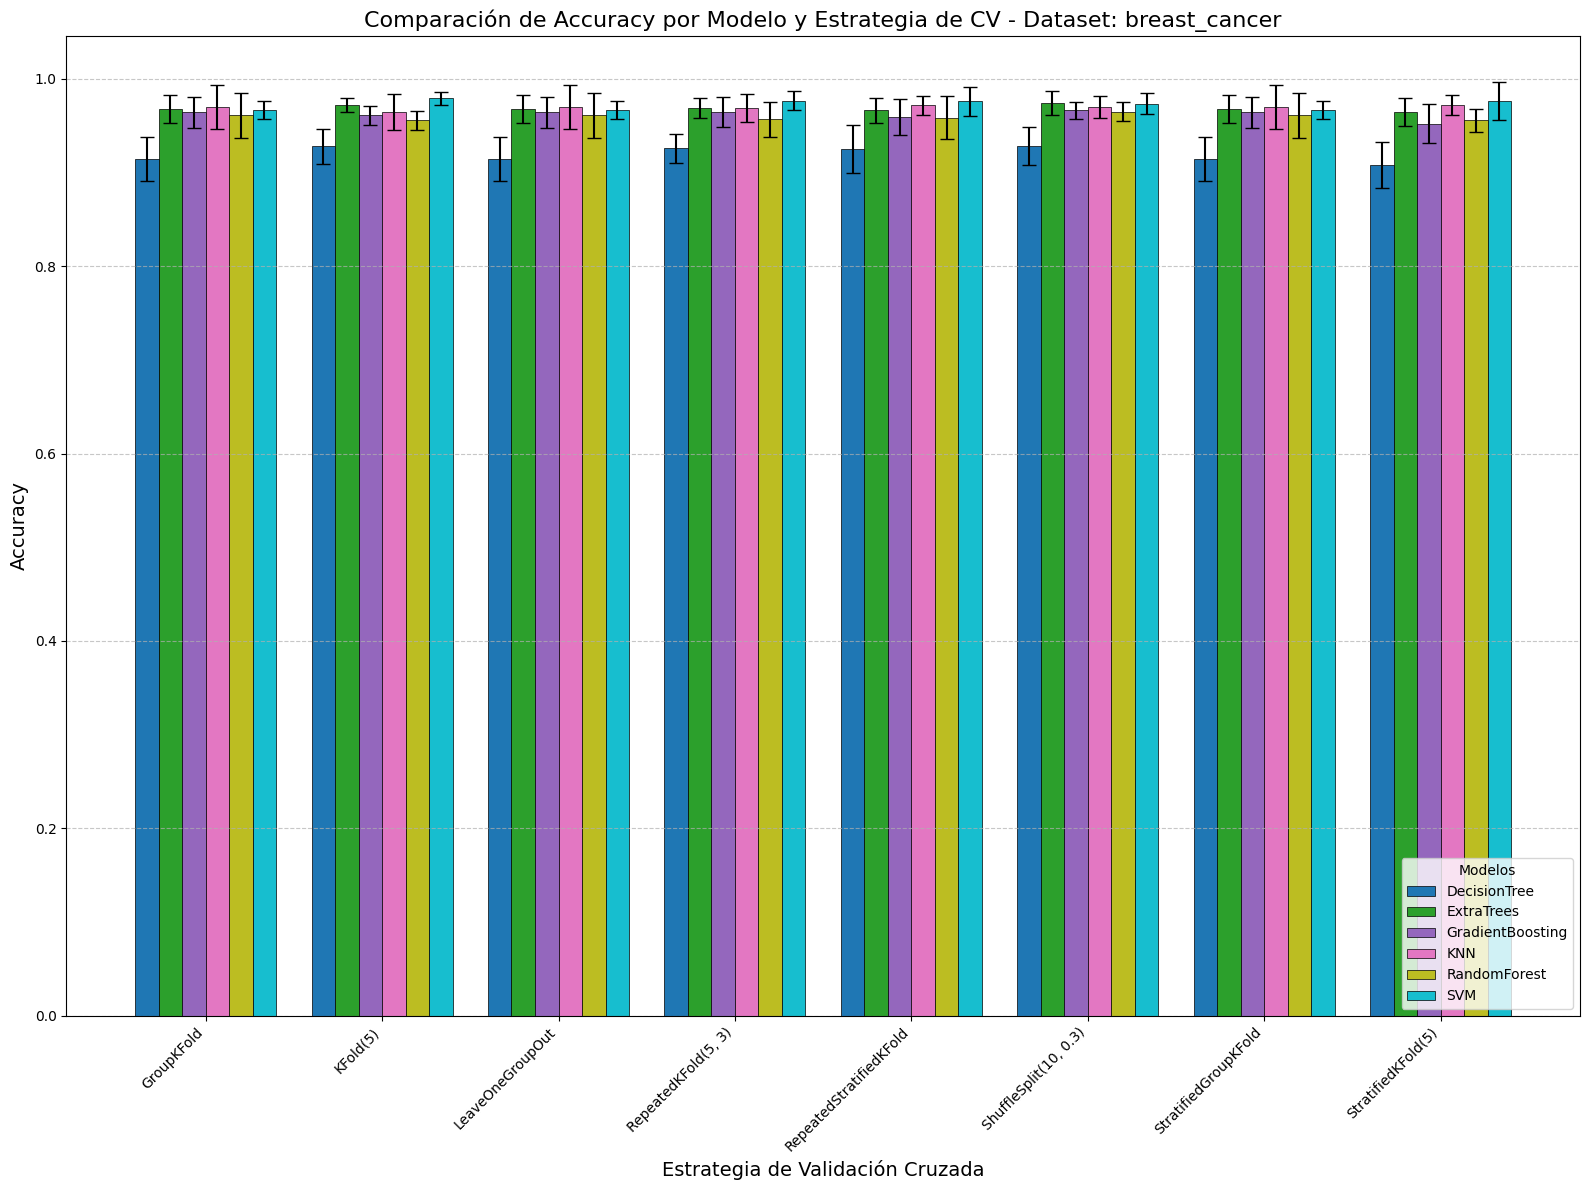


======= ANÁLISIS ROC AUC =======
Mejor modelo por AUC promedio: SVM (AUC promedio: 0.9949)


/tmp/ipykernel_7664/1050532765.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Mejor modelo por AUC promedio: {best_model_name} (AUC promedio: {avg_auc[0]:.4f})")


<Figure size 1400x800 with 0 Axes>

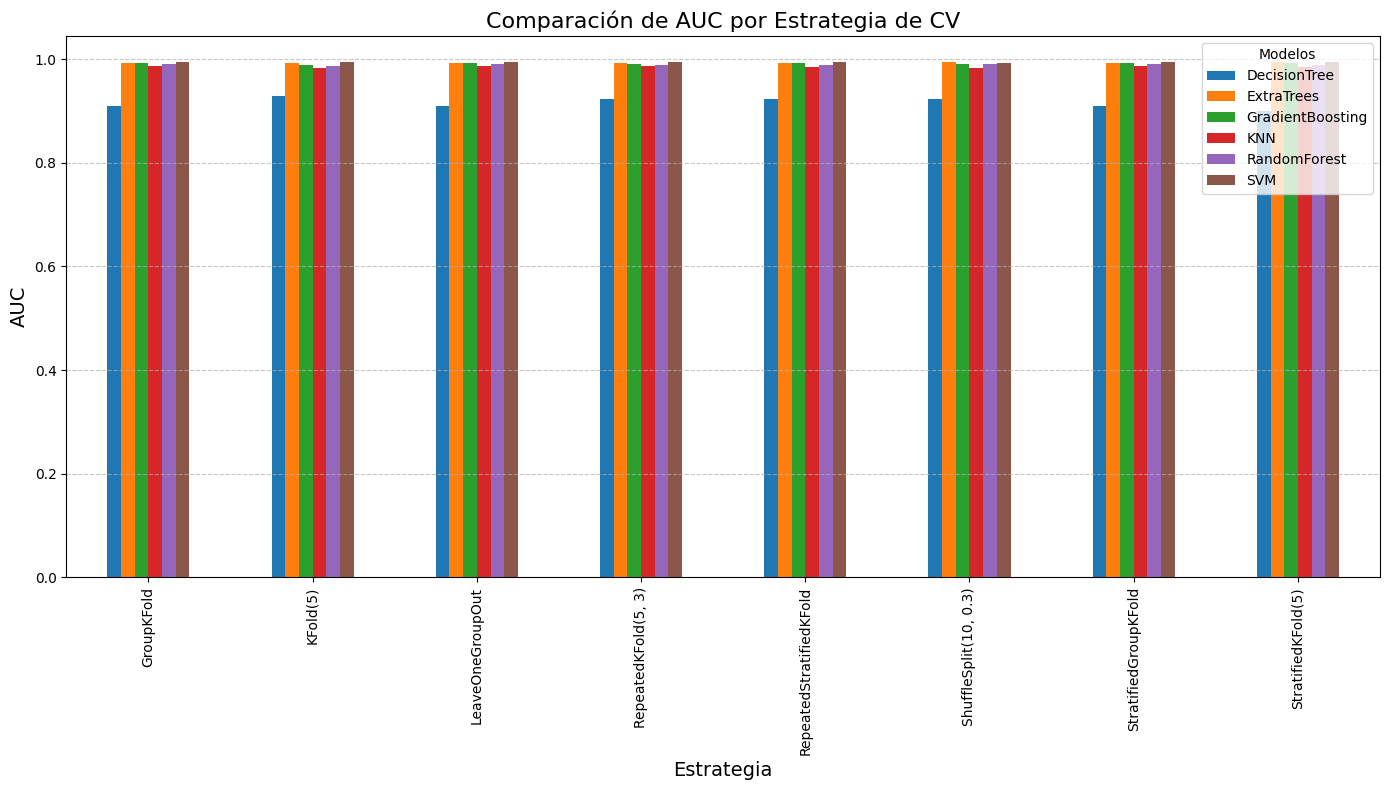

In [ ]:
# Visualización: Gráfico comparativo para la métrica principal (Accuracy)
plt.figure(figsize=(16, 12))

# Usar Accuracy como métrica común para ambos datasets
accuracy_results = results_df[results_df['Metric'] == 'Precision'].copy()

# Ordenar estrategias por nombre para consistencia visual
strategies = sorted(accuracy_results['Strategy'].unique())

# Calcular posiciones para las barras
n_models = len(models)
n_groups = len(strategies)
bar_width = 0.8 / n_models
indices = np.arange(n_groups)

# Colores para los modelos
colors = plt.cm.tab10(np.linspace(0, 1, n_models))

# Dibujar barras para cada modelo
for i, model_name in enumerate(sorted(models.keys())):
    model_data = accuracy_results[accuracy_results['Model'] == model_name]
    
    # Preparar datos ordenados por estrategia
    means = []
    stds = []
    for strategy in strategies:
        strategy_data = model_data[model_data['Strategy'] == strategy]
        if not strategy_data.empty:
            means.append(strategy_data['Mean'].values[0])
            stds.append(strategy_data['Std'].values[0])
        else:
            means.append(0)
            stds.append(0)
    
    # Posición para este modelo
    position = indices + (i - n_models/2 + 0.5) * bar_width
    
    # Dibujar barras
    plt.bar(position, means, width=bar_width, label=model_name, 
            yerr=stds, capsize=5, color=colors[i], edgecolor='black', linewidth=0.5)

# Configurar gráfico
plt.title(f'Comparación de Accuracy por Modelo y Estrategia de CV - Dataset: {dataset_name}', fontsize=16)
plt.xlabel('Estrategia de Validación Cruzada', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(indices, strategies, rotation=45, ha='right')
plt.legend(title='Modelos', loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostrar gráfico
plt.savefig(f'comparacion_modelos_cv_{dataset_name}.png')
plt.show()


# Análisis ROC AUC (solo para clasificación binaria)
if not multi_class and 'AUC' in metric_display.values():
    print("\n======= ANÁLISIS ROC AUC =======")
    
    # Filtrar resultados para la métrica AUC
    auc_results = results_df[results_df['Metric'] == 'AUC']
    
    # Encontrar el mejor modelo por AUC promedio en todas las estrategias
    avg_auc = auc_results.groupby('Model')['Mean'].mean().sort_values(ascending=False)
    best_model_name = avg_auc.index[0]
    
    print(f"Mejor modelo por AUC promedio: {best_model_name} (AUC promedio: {avg_auc[0]:.4f})")
    
    # Visualización de comparación de AUC por estrategia
    plt.figure(figsize=(14, 8))
    
    # Ordenar modelos por AUC promedio para la leyenda
    models_by_auc = avg_auc.index
    
    # Mostrar AUC por estrategia de CV para cada modelo
    auc_pivot = pd.pivot_table(
        auc_results,
        values='Mean',
        index='Strategy',
        columns='Model'
    )
    
    # Gráfico de barras
    auc_pivot.plot(kind='bar', figsize=(14, 8))
    plt.title('Comparación de AUC por Estrategia de CV', fontsize=16)
    plt.xlabel('Estrategia', fontsize=14)
    plt.ylabel('AUC', fontsize=14)
    plt.legend(title='Modelos')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    plt.show()

# Evaluación regresión

In [ ]:
import pandas as pd
import numpy as np
from sklearn import datasets

diabetes = datasets.load_diabetes(as_frame=True)

X = diabetes.data
y = diabetes.target

X.info()

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

sc = StandardScaler()
X_std = sc.fit_transform(X)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

models_reg = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'ExtraTrees': ExtraTreesRegressor(random_state=42),
    'KNN': KNeighborsRegressor(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'SVM (rbf)': SVR(kernel='rbf')
}

results_reg = [[0] * 4 for _ in range(len(models_reg))] 

for i, (name, model) in enumerate(models_reg.items()):
    model.fit(X_std, y)
    y_pred = model.predict(X_std)
    
    # evaluamos las métricas
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    results_reg[i] = [name, mae, mse, r2]

results = pd.DataFrame(results_reg, columns=['Modelo', 'MAE', 'MSE', 'R2'])


print("\nMétricas de rendimiento:")
print(results.set_index('Modelo').round(3))

best_mae = results.loc[results['MAE'].idxmin()]['Modelo']
best_mse = results.loc[results['MSE'].idxmin()]['Modelo']
best_r2 = results.loc[results['R2'].idxmax()]['Modelo']

print(f"Mejor modelo según MAE: {best_mae}")
print(f"Mejor modelo según MSE: {best_mse}")
print(f"Mejor modelo según R2: {best_r2}")

# normalizamos las métricas para que todas tengan la misma escala (0-1)
results['MAE_norm'] = (results['MAE'] - results['MAE'].min()) / (results['MAE'].max() - results['MAE'].min())
results['MSE_norm'] = (results['MSE'] - results['MSE'].min()) / (results['MSE'].max() - results['MSE'].min())
results['R2_norm'] = 1 - (results['R2'] - results['R2'].min()) / (results['R2'].max() - results['R2'].min())


results['Score'] = (results['MAE_norm'] + results['MSE_norm'] + results['R2_norm']) / 3

print("\nClasificación de modelos:")
print(results[['Modelo', 'Score']].sort_values('Score'))

final_best = results.loc[results['Score'].idxmin()]['Modelo']
print(f"\nEl mejor modelo general es: {final_best}")

# Comparación de modelos

## Dos clasificadores un dominio

1. **Comprobar las condiciones de aplicabilidad del test T de Student** con medidas pareadas. **La normalidad hay que comprobarla sobre las diferencias entre las medidas** obtenidas en cada pliegue, ya que lo que queremos comprobar es si existen diferencias significativas entre las medias del rendimiento entre las dos clasificadores. En nuestro caso el test intenta comprobar estas hipótesis:

$$ H_0: X \sim N(\mu, \sigma^2) $$
$$ H_1: X \nsim N(\mu, \sigma^2) $$

Si los p-valores son mayores de 0.05, **no podemos rechazar la hipótesis nula** (la muestra procede de una distribución normal) con un 95% de confianza. na vez comprobada la normalidad, hay que proceder con la comprobación de **la homocedasticidad** (homogeneidad de las varianzas). Para ello tenemos dos test: el **test de Levene** y el **test de Bartlett**. Este último es más potente en el caso de que se pueda asumir la normalidad, como es nuestro caso.

2. Al cumplirse las condiciones de aplicabilidad del test T de Student con medidas pareadas, podemos comprobar si las diferencias detectadas en los clasificadores es significativa o no. Es decir, las hipótesis que intenta comprobar el test se pueden expresar de la siguiente manera:

$$ H_0: \mu_{C50} − \mu_{nnet} = 0 $$
$$ H_q: \mu_{C50} − \mu_{nnet} \neq 0 $$

In [13]:
from pingouin import normality, homoscedasticity, ttest

shapiro = normality(results['nnet'] - results['C50'], method='shapiro')

print('### Test de normalidad Shapiro-Wilk')
print(f'### estadístico = {shapiro.W.values[0]:.4f}, p-value = {shapiro.pval.values[0]:.4f}')

normtest = normality(results['nnet'] - results['C50'], method='normaltest')

print('### Test de normalidad omnibus')
print(f'### estadístico = {normtest.W.values[0]:.4f}, p-value = {normtest.pval.values[0]:.4f}')

jaquebera = normality(results['nnet'] - results['C50'], method='jarque_bera')

print('### Test de normalidad Jaque-Bera')
print(f'### estadístico = {jaquebera.W.values[0]:.4f}, p-value = {jaquebera.pval.values[0]:.4f}')


levene = homoscedasticity(results[['nnet', 'C50']], method='levene')

print('### Test de Levene para la homogeneidad de las varianzas')
print(f'### estadístico = {levene.W.values[0]:.4f}, p-value = {levene.pval.values[0]:.4f}')

bartlett = homoscedasticity(results[['nnet', 'C50']], method='bartlett')

print('### Test de Bartlett para la homogeneidad de las varianzas')
print(f"### estadístico = {bartlett['T'].values[0]:.4f}, p-value = {bartlett.pval.values[0]:.4f}")


t = ttest(results['nnet'], results['C50'], paired=True)
#t = ttest(results['nnet'] - results['C50'], 0) # version para una muestra

print('### Test T de medias pareadas')
print(f"### estadistico = {t['T'].values[0]:.4f}, p-value = {t['p-val'].values[0]:.4f}")

TypeError: list indices must be integers or slices, not str

3. Si no se cumplen (distribuciones no normales o varianzas no homogéneas), se puede recurrir a un test no paramétrico como el **test de Wilcoxon**.
    * El **test de McNemar** necesita como datos la **matriz de confusión** para los dos métodos considerados, y comprueba si las **proporciones de error son iguales**, es decir:
    $$ H_0: p_{FP}=p_{FN} $$
    $$ H_1: p_{FP} \neq p_{FN} $$
    * El **test de Wilcoxon** compara las medianas de las dos muestras en vez de las medias. Las hipótesis que comprueba este test se pueden expresar de la siguiente manera:

    $$ H0: \eta_{SVM} = \eta_{LDA} $$
    $$ H1: \eta_{SVM} \neq \eta_{LDA} $$

In [ ]:
from statsmodels.stats.contingency_tables import mcnemar
from pingouin import chi2_mcnemar, wilcoxon

observed = pd.DataFrame([{"actual": 0,"predicted": 0}] * matrix['FALLECE']['FALLECE'] + [{"actual": 0,"predicted": 1}] * matrix['FALLECE']['VIVE'] + [{"actual": 1,"predicted": 0}] * matrix['VIVE']['FALLECE'] + [{"actual": 1,"predicted": 1}] * matrix['VIVE']['VIVE'])

mcnemar = chi2_mcnemar(observed, "predicted", "actual")

print('### Test de McNemar')
print(f"### estadistico = {mcnemar[1].chi2.values[0]:.4f}, p-value = {mcnemar[1]['p-exact'].values[0]:.4f}")


wil = wilcoxon(results['SVM'], results['LDA'])

print('### Test de signos de Wilcoxon')
print(f"### estadistico = {wil['W-val'].values[0]:.4f}, p-value = {wil['p-val'].values[0]:.4f}")

# Dos predictores en multiples dominios

Para comparar dos modelos empleando múltiples dominios la recomendación es utilizar el **test de la suma de rangos de Wilcoxon para muestras pareadas** (o su versión de una muestra, calculando la diferencia en las metricas obtenida en cada dataset).

In [ ]:
from pingouin import wilcoxon

wil = wilcoxon(results['SVMLinear'], results['C50'])

print('### Test de signos de Wilcoxon')
print(f"### estadistico = {wil['W-val'].values[0]:.4f}, p-value = {wil['p-val'].values[0]:.4f}")

# Múltiples predictores en múltiples dominios 

Para comparar múltiples clasificadores en múltiples dominios aplicaremos el **test ANOVA de una vía para medidas pareadas** o su equivalente no paramétrico, el **test de Friedman**. 

Primero transformaremos el conjunto de datos a un formato de tabla larga (ver .ipynb).

Comprobar si tienen la misma media a través del **test de ANOVA**. 
Para ello debemos de comprobar las **condiciones de aplicabilidad**: normalidad y esfericidad (en el caso de un ANOVA con medidas repetidas se traduce en comprobar la **esfericidad** de la matriz de covarianzas. ).

En el caso del test ANOVA de una vía para medidas pareadas se comprueba si las medias entre los diferentes clasificadores son iguales, es decir:

$$ H0: \mu_1 = \mu_2 = \dots = \mu_n $$
$$ H1: \text{las medias no son iguales} $$

Para la condición de normalidad, debemos comprobar que la muestra de cada uno de los grupos procede de una población con distribución normal. Como hemos comentado anteriormente, esto se puede realizar mediante el test de Shapiro-Wilks:

In [ ]:
from pingouin import normality

shapiro_a = normality(data.loc[data["Method"] == "Classifier A"]['Precision'], method='shapiro')
shapiro_b = normality(data.loc[data["Method"] == "Classifier B"]['Precision'], method='shapiro')
shapiro_c = normality(data.loc[data["Method"] == "Classifier C"]['Precision'], method='shapiro')

print('### Test de normalidad Shapiro-Wilk para el clasificador A')
print(f'### estadístico = {shapiro_a.W.values[0]:.4f}, p-value = {shapiro_a.pval.values[0]:.4f}')

print('### Test de normalidad Shapiro-Wilk para el clasificador B')
print(f'### estadístico = {shapiro_b.W.values[0]:.4f}, p-value = {shapiro_b.pval.values[0]:.4f}')

print('### Test de normalidad Shapiro-Wilk para el clasificador C')
print(f'### estadístico = {shapiro_c.W.values[0]:.4f}, p-value = {shapiro_c.pval.values[0]:.4f}')

from pingouin import sphericity

esfericidad = sphericity(data = data, dv = 'Precision', within = 'Method', subject = 'dataset', alpha = 0.05)

print(f'Estadistico: {esfericidad.W:.3f} p-value: {esfericidad.pval:.4f}')

### Test ANOVA

In [ ]:
from pingouin import anova

anova = anova(data = data, dv = 'Precision', between = 'Method', detailed = True)

anova


El proceso de comprobar la esfericidad de los datos y a continuación realizar el test ANOVA podemos resumirlos tambien en un único paso empleando la función `rm_anova`:

In [ ]:
from pingouin import rm_anova

rm_anova(data = data, dv = 'Precision', within = 'Method', subject = 'dataset', detailed = True, correction = True)

Las columnas sphericity y p-spher  (p-valor) se corresponden con el test de Mauchly para la esfericidad, que nos indica que no podemos rechazar la hipótesis de que la matriz de covarianzas cumpla esta propiedad. Las columnas eps (Greenhouse-Geisser epsilon factor) y p-GG-corr (p-valor) muestran el resultado de aplicar un procedimiento que permite corregir la desviación producida por cumplir con la esfericidad a los resultados de test ANOVA anteriormente realizados.

Una vez sabemos que los predictores no son iguales podemos proceder a identificar donde están las diferencias. Para eso emplearemos el **test de Tukey**.

In [ ]:
from pingouin import pairwise_tukey

comparative = pairwise_tukey(data = data, dv = 'Precision', between = 'Method')

comparative

### Test Friedman

In [ ]:
from pingouin import friedman

friedman = friedman(data = data, dv = 'Kappa', within = 'Method', subject = 'Dataset')

print('### Test de Friedman')
print(f'### estadistico = {friedman.W.values[0]:.4f} p-value = {friedman["p-unc"].values[0]:.4f}')

na vez confirmado la existencia de diferencias entre los clasificadores, podemos aplicar un **test de pares no parametrico** para comprobar donde está la diferencia.

In [ ]:
from pingouin import pairwise_tests

pairwise_tests(data = data, dv = 'Kappa', within = 'Method', subject = 'Dataset', parametric = False, marginal = True, return_desc=True)